In [1]:
import os
def download_from_kaggle(): 
    os.environ['KAGGLE_CONFIG_DIR'] = "Kaggle"  
    !chmod 600 Kaggle/kaggle.json
    print("---------------------------------------------------------------------------")
    print("\nDownloading dataset of ECG Heartbeat Categorization Dataset  from Kaggle")
    !kaggle datasets download -d shayanfazeli/heartbeat
    print("---------------------------------------------------------------------------")

In [3]:
download_from_kaggle()

---------------------------------------------------------------------------

 90% 89.0M/98.8M [00:04<00:00, 18.8MB/s]
100% 98.8M/98.8M [00:04<00:00, 25.1MB/s]
---------------------------------------------------------------------------


In [6]:
!pip install -r /content/requirements2.txt

     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 198 kB 46.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=15652104c9e84f50dac05707bb4929f310f8a9b394d58ac6feb54fc56b43cf80
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [4]:
!unzip /content/heartbeat.zip

Archive:  /content/heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


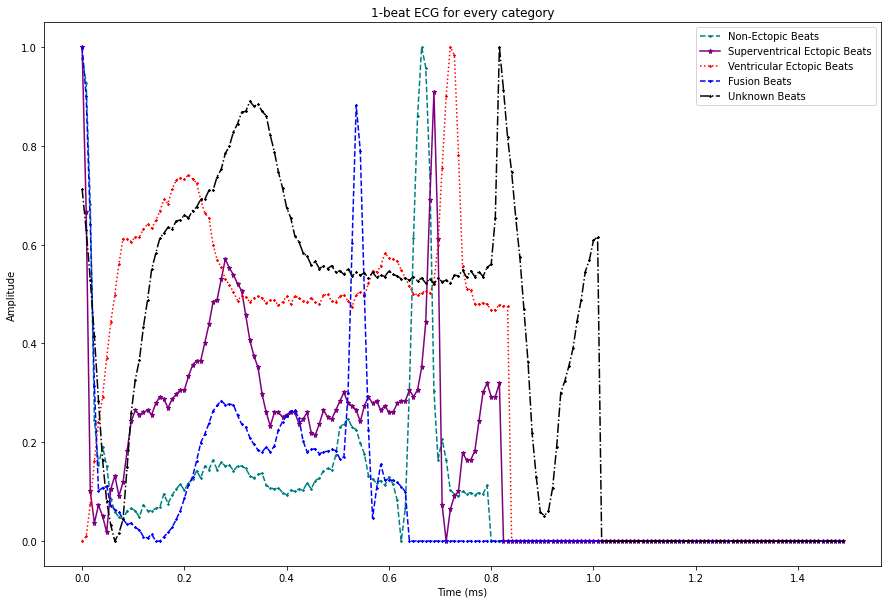

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("mitbih_train.csv", header=None)
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

x = np.arange(0, 187)*8/1000


fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x,X[C0, :][0], marker='*', markersize=2, color='teal',linestyle='dashed', label="Non-Ectopic Beats")
ax.plot(x,X[C1, :][0], marker='*', markersize=5, color='purple', label="Superventrical Ectopic Beats")
ax.plot(x,X[C2, :][0], marker='*', markersize=2, color='red',linestyle=':', label="Ventricular Ectopic Beats")
ax.plot(x,X[C3, :][0], marker='*', markersize=2, color='blue',linestyle='dashed', label="Fusion Beats")
ax.plot(x,X[C4, :][0], marker='*', markersize=2, color='black',linestyle='-.', label="Unknown Beats")

ax.legend()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude')
ax.set_title('1-beat ECG for every category');

In [1]:
import os
import numpy as np 
import pandas as pd 
import time 

# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

#Create PySpark SparkSession
conf = SparkConf().setAppName('Spark Deep Learning processing phase').setMaster('local[3]')
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)

# Load Data to Spark Dataframe
df_train = sql_context.read.csv('mitbih_train.csv',
                    header=False,
                    inferSchema=True)

df_val= sql_context.read.csv('mitbih_test.csv',
                    header=False,
                    inferSchema=True)

df_abnormal = sql_context.read.csv('ptbdb_abnormal.csv',
                    header=False,
                    inferSchema=True)

df_normal = sql_context.read.csv('ptbdb_normal.csv',
                    header=False,
                    inferSchema=True)    

 
df_val.printSchema()
df_val.show(100)    

df_abnormal = df_abnormal.drop('_c187')
df_normal = df_normal.drop('_c187')

flatten_y = df_abnormal.toPandas().values
flatten_y = flatten_y[:, 5:70].flatten()

data_1 = df_train[df_train[187] == 1]
data_2 = df_train[df_train[187] == 2]
data_3 = df_train[df_train[187] == 3]
data_4 = df_train[df_train[187] == 4]

y_abnormal = np.ones(df_abnormal.count())
y_abnormal = pd.DataFrame(y_abnormal)

y_normal = np.zeros(df_normal.count())
y_normal = pd.DataFrame(y_normal)

X_test = pd.concat([df_abnormal.toPandas(),df_normal.toPandas()], sort=True)
y_test = pd.concat([y_abnormal, y_normal], sort=True)

N_SAMP = 20000

RAND = 225

from sklearn.utils import resample
data_1_resample = resample(data_1.toPandas(), n_samples=N_SAMP, 
                           random_state=RAND, replace=True)
data_2_resample = resample(data_2.toPandas(), n_samples=N_SAMP, 
                           random_state=RAND, replace=True)
data_3_resample = resample(data_3.toPandas(), n_samples=N_SAMP, 
                           random_state=RAND, replace=True)
data_4_resample = resample(data_4.toPandas(), n_samples=N_SAMP, 
                           random_state=RAND, replace=True)
data_0 = df_train[df_train[187] == 0].toPandas().sample(n=N_SAMP, random_state=RAND)



train_dataset = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample, 
                          data_4_resample])

val_dataset = df_val.toPandas()

VER=2

train_name="train_dataset_" + str(VER) + ".csv"
val_name="val_dataset_" + str(VER) + ".csv"

train_dataset.to_csv(train_name)
val_dataset.to_csv(val_name)
X_test.to_csv("X_test.csv")
y_test.to_csv("y_test.csv")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

In [ ]:
!pip install -r /content/requirements.txt

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 187, 64)           448       
                                                                 
 batch_normalization_30 (Bat  (None, 187, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 94, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 94, 64)            24640     
                                                                 
 batch_normalization_31 (Bat  (None, 94, 64)           256       
 chNormalization)                                                
                                                     

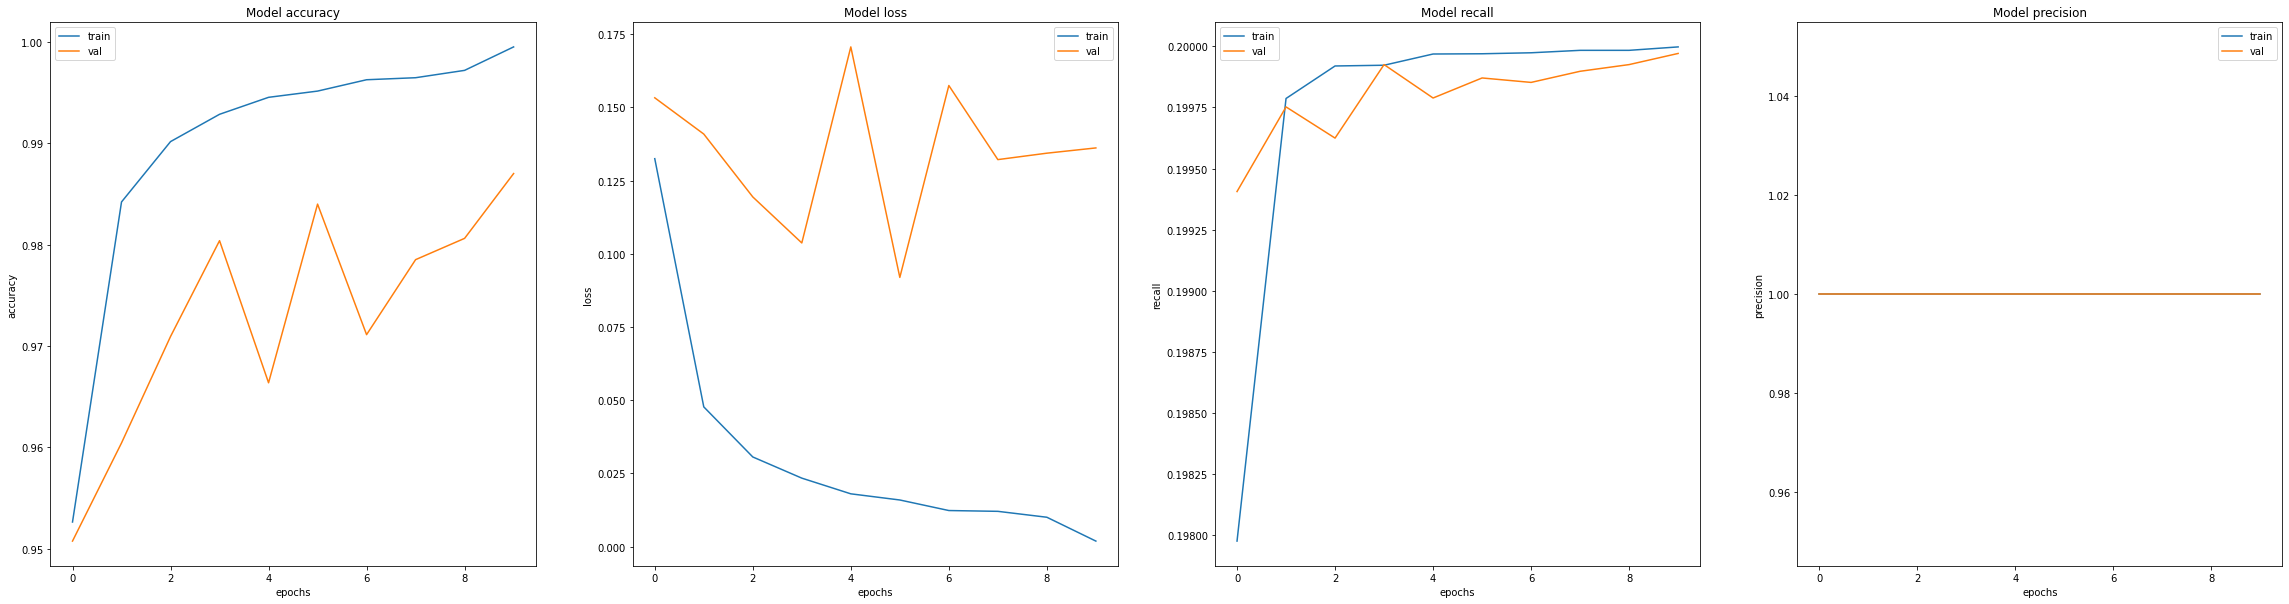

In [14]:
import os
import numpy as np 
import pandas as pd 
import os, time 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K


def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
  union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

  
train_set_1=pd.read_csv("train_dataset_1.csv")
train_set_2=pd.read_csv("train_dataset_2.csv")
val_set_1=pd.read_csv("val_dataset_1.csv")
val_set_2=pd.read_csv("val_dataset_2.csv")


train_dataset = pd.concat([train_set_1,train_set_2])
val_dataset=pd.concat([val_set_1,val_set_2])

if "Unnamed: 0" in train_dataset.columns:
  train_dataset.drop({"Unnamed: 0"},axis="columns",inplace=True,)

if "Unnamed: 0" in val_dataset.columns:
  val_dataset.drop({"Unnamed: 0"},axis="columns",inplace=True,)


target_train = train_dataset['_c187']
target_val = val_dataset['_c187']
y_train = to_categorical(target_train)
y_val = to_categorical(target_val)
X_train = train_dataset.iloc[:, :-1].values
X_val = val_dataset.iloc[:, :-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], 1)                          

# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[iou_coef,'accuracy',recall,precision])
    return model

model = model()
model.summary()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=1e-3,
                                                 min_lr=1e-7)

target_dir = '/content/snapshots'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)

file_path = '/content/snapshots/best_weight{epoch:03d}.h5'
checkpoints = tf.keras.callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto')

cbks = [ checkpoints, reduce_lr]

logger = CSVLogger('logs.csv', append=True)
with tf.device('/GPU:0'):
    his = model.fit(X_train, y_train, epochs=10, batch_size=32,validation_data=(X_val, y_val), callbacks=[logger,cbks])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss","recall","precision"]):
    ax[i].plot(model.history.history[metric][:])
    ax[i].plot(model.history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

fig.savefig('metric.png')   


MODEL_FILE ="model.h5"
from joblib import dump, load
model.save(MODEL_FILE)
print("Model Saved successfully")

print(os.listdir())

print("Done")


Confusion matrix for model on Test set
[[36046    98    54    32     6]
 [  154   928    22     6     2]
 [   54     8  2792    34     8]
 [   26     0    34   264     0]
 [   30     0     0     0  3186]]
Evaluation is done successfully


<Figure size 360x360 with 0 Axes>

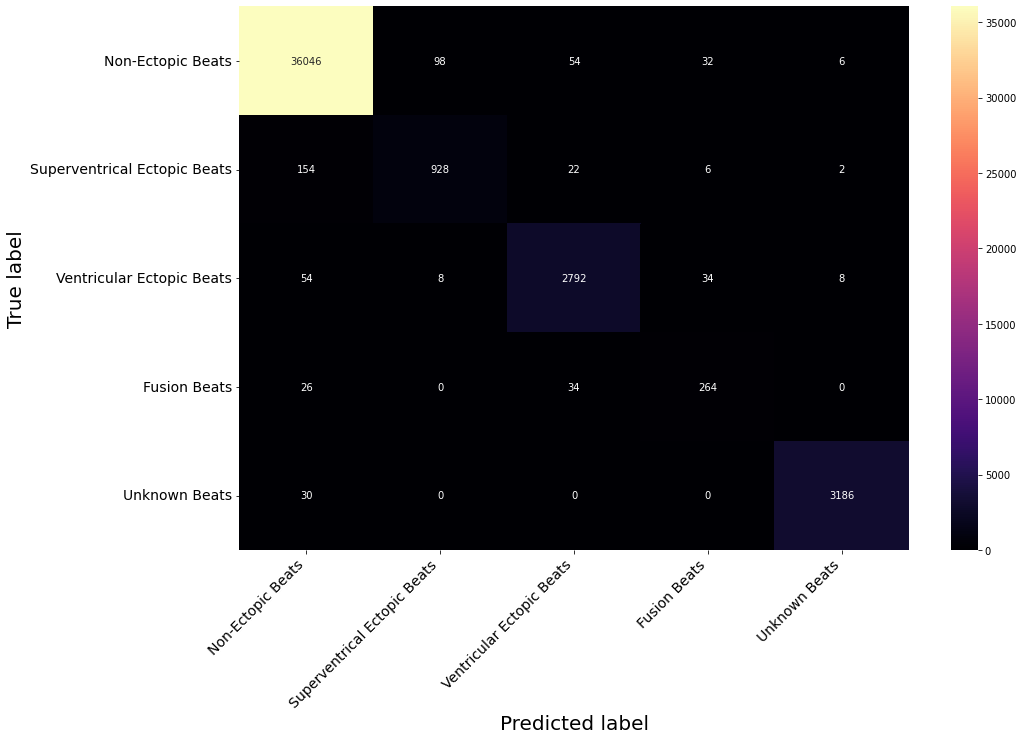

In [19]:
import os
import numpy as np 
import pandas as pd 
import os, time 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1])
  union = K.sum(y_true,[1])+K.sum(y_pred,[1])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))


test_set_1=pd.read_csv("test_dataset_1.csv")
test_set_2=pd.read_csv("test_dataset_2.csv")

data_test=pd.concat([test_set_1,test_set_2])

if "Unnamed: 0" in data_test.columns:
  data_test.drop({"Unnamed: 0"},axis="columns",inplace=True,)

target_test = data_test['_c187']  

y_test = to_categorical(target_test)

X_test = data_test.iloc[:, :-1].values

X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)    


# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    
    return model

model = model()    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[iou_coef,'accuracy',recall,precision])
model.load_weights("model.h5")

print("Confusion matrix for model on Test set")
y_pred = model.predict(X_test)
y_hat = np.argmax(y_pred, axis = 1)
print(confusion_matrix(np.argmax(y_test, axis = 1), y_hat))

label_dict = ['Non-Ectopic Beats','Superventrical Ectopic Beats','Ventricular Ectopic Beats','Fusion Beats','Unknown Beats']

def print_confusion_matrix(confusion_matrix, class_names, figsize = (15,10), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap='magma')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    fig.savefig('confusion_matrix.png')
    return fig

plt.figure(figsize=(5,5))
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_hat)
print_confusion_matrix(cm, label_dict)

print("Evaluation is done successfully")